In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class MultiHeadFuzzyAttentionLayer(nn.Module):
    def __init__(self, input_features, output_features, num_clusters, num_heads, num_fuzzy_layers, input_embedding_size):
        super(MultiHeadFuzzyAttentionLayer, self).__init__()
        
        self.embedding = nn.Linear(input_features, input_embedding_size)
        assert input_embedding_size % num_heads == 0, "Input embedding size must be divisible by the number of heads"
        self.head_dim = input_embedding_size // num_heads
        self.num_heads = num_heads

        # Initialize Fuzzy Layer parameters for each head
        self._init_fuzzy_parameters(num_clusters, num_fuzzy_layers)

        self.sm = torch.nn.Softmax(dim=2)
        self.combine_heads = nn.Linear(num_heads * self.head_dim, output_features)

    def _init_fuzzy_parameters(self, num_clusters, num_fuzzy_layers):
        self.mus = nn.ModuleList([nn.ParameterList([torch.nn.Parameter(data= 10*(torch.rand(num_clusters, self.head_dim) - 1/2), requires_grad=True) for _ in range(num_fuzzy_layers)]) for _ in range(self.num_heads)])
        self.sigma_invs = nn.ModuleList([nn.ParameterList([nn.Parameter(torch.zeros(num_clusters, self.head_dim, self.head_dim), requires_grad=True) for _ in range(num_fuzzy_layers)]) for _ in range(self.num_heads)])
        
        for sigma_invs_head in self.sigma_invs:
            for sigma_inv in sigma_invs_head:
                with torch.no_grad():
                    sigma_inv.diagonal(dim1=-2, dim2=-1).fill_(1)
        
        self.lin_fuzzies = nn.ModuleList([nn.ModuleList([torch.nn.Linear(self.head_dim, num_clusters * self.head_dim) for _ in range(num_fuzzy_layers)]) for _ in range(self.num_heads)])

    def _compute_psi(self, z, mu, sigma_inv):
        d = torch.sub(mu.unsqueeze(0).unsqueeze(0), z.unsqueeze(2))
        d_expanded = d.unsqueeze(-2)
        sigma_inv_expanded = sigma_inv.unsqueeze(0).unsqueeze(1)
        d2_part = d_expanded @ sigma_inv_expanded @ d.unsqueeze(-1)
        d2 = d2_part.squeeze(-1).squeeze(-1)
        psi = self.sm(-d2)
        return psi

    def _process_head(self, x_head, idx):
        for j in range(len(self.lin_fuzzies[idx])):
            psi = self._compute_psi(x_head, self.mus[idx][j], self.sigma_invs[idx][j])
            x_transformed = self.lin_fuzzies[idx][j](x_head).view(x_head.shape[0], x_head.shape[1], psi.shape[2], -1)
            x_head = torch.einsum('btl,btlf->btf', psi, x_transformed)
        return x_head

    def forward(self, x):
        x = self.embedding(x)
        x_heads = torch.chunk(x, self.num_heads, dim=-1)
        outputs = [self._process_head(x_head, idx) for idx, x_head in enumerate(x_heads)]
        concatenated_output = torch.cat(outputs, dim=-1)
        return self.combine_heads(concatenated_output)

# Test the refactored MultiHeadFuzzyAttentionLayer
multi_head_attention_layer = MultiHeadFuzzyAttentionLayer(input_features=5, output_features=5, num_clusters=8, num_heads=8, num_fuzzy_layers=2, input_embedding_size=32)
dummy_input = torch.randn(10, 3, 5)
output = multi_head_attention_layer(dummy_input)
output.shape

torch.Size([10, 3, 5])

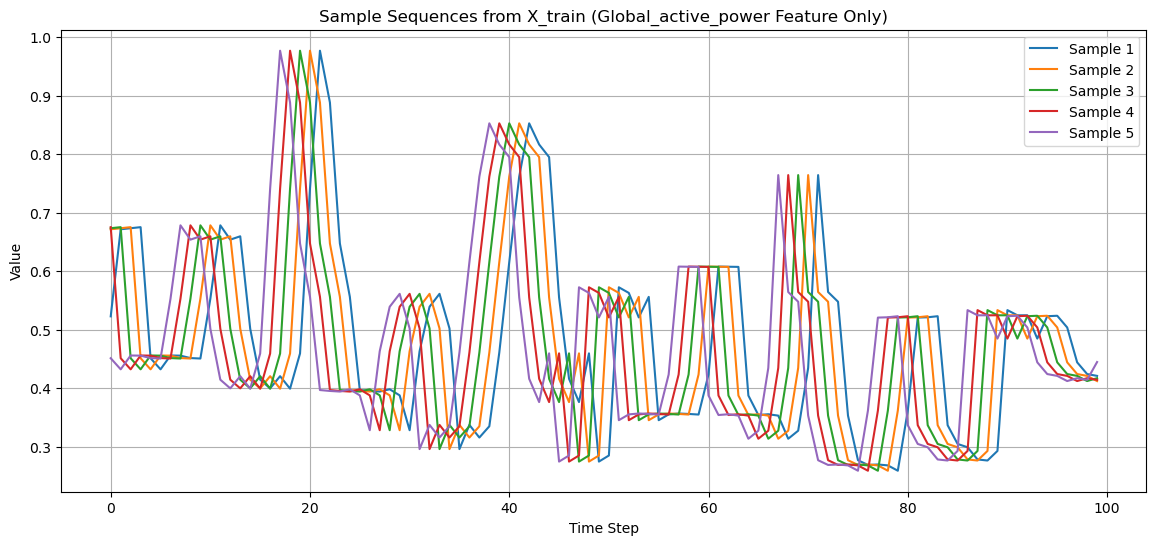

In [55]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch

# Parameters and data setup
forecast_steps = 60
input_window_size = 100

# 1. Load the dataset (using the first 10,000 data points)
data = pd.read_csv('household_power_consumption.txt', delimiter=';', 
                   parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, 
                   low_memory=False, na_values=['nan', '?'], nrows=10000)  # Limit to 10,000 rows
data.set_index('datetime', inplace=True)

# 2. Preprocess the dataset

# 2.1 Handling Missing Values
data.interpolate(method='time', inplace=True)

# 2.2 Normalize the Dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Segmenting the Dataset for Forecasting

def create_forecasting_data(data, input_window_size, forecast_steps):
    """Segment the time series data for forecasting."""
    X = torch.stack([data[i:i+input_window_size] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    y = torch.stack([data[i+input_window_size:i+input_window_size+forecast_steps] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    return X, y

data_tensor = torch.tensor(scaled_data, dtype=torch.float32)
X_train, y_train = create_forecasting_data(data_tensor, input_window_size, forecast_steps)

# 4. Visualization
plt.figure(figsize=(14, 6))
for i in range(5):
    plt.plot(range(input_window_size), X_train[i, :, 0], label=f"Sample {i+1}")
plt.title("Sample Sequences from X_train (Global_active_power Feature Only)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
num_features = 7
input_dim = 7
num_clusters_list = [2, 1, 1]
num_fuzzy_layers_list = [2, 1, 1]
num_heads = 8  # Number of heads for the MultiHeadFuzzyAttentionLayer

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class MultiHeadFuzzyAttentionLayer(nn.Module):
    def __init__(self, input_features, output_features, num_clusters, num_heads, num_fuzzy_layers, input_embedding_size):
        super(MultiHeadFuzzyAttentionLayer, self).__init__()
        
        self.embedding = nn.Linear(input_features, input_embedding_size)
        assert input_embedding_size % num_heads == 0, "Input embedding size must be divisible by the number of heads"
        self.head_dim = input_embedding_size // num_heads
        self.num_heads = num_heads

        # Initialize Fuzzy Layer parameters for each head
        self._init_fuzzy_parameters(num_clusters, num_fuzzy_layers)

        self.sm = torch.nn.Softmax(dim=2)
        self.combine_heads = nn.Linear(num_heads * self.head_dim, output_features)

    def _init_fuzzy_parameters(self, num_clusters, num_fuzzy_layers):
        self.mus = nn.ModuleList([nn.ParameterList([torch.nn.Parameter(data= 10*(torch.rand(num_clusters, self.head_dim) - 1/2), requires_grad=True) for _ in range(num_fuzzy_layers)]) for _ in range(self.num_heads)])
        self.sigma_invs = nn.ModuleList([nn.ParameterList([nn.Parameter(torch.zeros(num_clusters, self.head_dim, self.head_dim), requires_grad=True) for _ in range(num_fuzzy_layers)]) for _ in range(self.num_heads)])
        
        for sigma_invs_head in self.sigma_invs:
            for sigma_inv in sigma_invs_head:
                with torch.no_grad():
                    sigma_inv.diagonal(dim1=-2, dim2=-1).fill_(1)
        
        self.lin_fuzzies = nn.ModuleList([nn.ModuleList([torch.nn.Linear(self.head_dim, num_clusters * self.head_dim) for _ in range(num_fuzzy_layers)]) for _ in range(self.num_heads)])

    def _compute_psi(self, z, mu, sigma_inv):
        d = torch.sub(mu.unsqueeze(0).unsqueeze(0), z.unsqueeze(2))
        d_expanded = d.unsqueeze(-2)
        sigma_inv_expanded = sigma_inv.unsqueeze(0).unsqueeze(1)
        d2_part = d_expanded @ sigma_inv_expanded @ d.unsqueeze(-1)
        d2 = d2_part.squeeze(-1).squeeze(-1)
        psi = self.sm(-d2)
        return psi

    def _process_head(self, x_head, idx):
        for j in range(len(self.lin_fuzzies[idx])):
            psi = self._compute_psi(x_head, self.mus[idx][j], self.sigma_invs[idx][j])
            x_transformed = self.lin_fuzzies[idx][j](x_head).view(x_head.shape[0], x_head.shape[1], psi.shape[2], -1)
            x_head = torch.einsum('btl,btlf->btf', psi, x_transformed)
        return x_head

    def forward(self, x):
        x = self.embedding(x)
        x_heads = torch.chunk(x, self.num_heads, dim=-1)
        outputs = [self._process_head(x_head, idx) for idx, x_head in enumerate(x_heads)]
        concatenated_output = torch.cat(outputs, dim=-1)
        return self.combine_heads(concatenated_output)

# Test the refactored MultiHeadFuzzyAttentionLayer
multi_head_attention_layer = MultiHeadFuzzyAttentionLayer(input_features=5, output_features=5, num_clusters=8, num_heads=8, num_fuzzy_layers=2, input_embedding_size=32)
dummy_input = torch.randn(10, 3, 5)
output = multi_head_attention_layer(dummy_input)
output.shape

torch.Size([10, 3, 5])

In [58]:

class MultiHeadForecastingNeuroFuzzyNetwork(nn.Module):
    def __init__(self, input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, output_dim, num_heads):
        super(MultiHeadForecastingNeuroFuzzyNetwork, self).__init__()
        
        assert len(num_clusters_list) == len(num_fuzzy_layers_list), "Mismatch in the length of num_clusters_list and num_fuzzy_layers_list"
        
        self.layers = nn.ModuleList()
        input_size = input_dim
        
        for num_clusters, num_fuzzy_layers in zip(num_clusters_list, num_fuzzy_layers_list):
            layer = MultiHeadFuzzyAttentionLayer(input_features=input_size, 
                                                 output_features=output_dim, 
                                                 num_clusters=num_clusters, 
                                                 num_heads=num_heads, 
                                                 num_fuzzy_layers=num_fuzzy_layers, 
                                                 input_embedding_size=input_size * num_heads)
            self.layers.append(layer)
            input_size = output_dim
        
        # Adjust the final layer to produce the correct shape
        self.final_layer = nn.Linear(input_window_size*input_size, forecast_steps * num_features)
        
        # Positional embeddings
        self.position_embedding = nn.Embedding(input_window_size, input_dim)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Generate position_ids based on the batch size
        position_ids = torch.arange(input_window_size).expand((batch_size, -1)).to(x.device)
        
        # Add positional embeddings
        pos_emb = self.position_embedding(position_ids)
        x_with_position = x + pos_emb
        
        layer_output = x_with_position
        for layer in self.layers:
            layer_output = layer(layer_output)

        flattened_output = layer_output.view(batch_size, -1)
        final_output = self.final_layer(flattened_output)
        
        return final_output.view(batch_size, forecast_steps, num_features)


# Test the updated model
model_with_positional_embedding = MultiHeadForecastingNeuroFuzzyNetwork(input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, input_dim, num_heads)
model_with_positional_embedding

MultiHeadForecastingNeuroFuzzyNetwork(
  (layers): ModuleList(
    (0): MultiHeadFuzzyAttentionLayer(
      (embedding): Linear(in_features=7, out_features=56, bias=True)
      (mus): ModuleList(
        (0): ParameterList(
            (0): Parameter containing: [torch.float32 of size 2x7]
            (1): Parameter containing: [torch.float32 of size 2x7]
        )
        (1): ParameterList(
            (0): Parameter containing: [torch.float32 of size 2x7]
            (1): Parameter containing: [torch.float32 of size 2x7]
        )
        (2): ParameterList(
            (0): Parameter containing: [torch.float32 of size 2x7]
            (1): Parameter containing: [torch.float32 of size 2x7]
        )
        (3): ParameterList(
            (0): Parameter containing: [torch.float32 of size 2x7]
            (1): Parameter containing: [torch.float32 of size 2x7]
        )
        (4): ParameterList(
            (0): Parameter containing: [torch.float32 of size 2x7]
            (1): Para

In [59]:

# DataLoader for training
batch_size = 513
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Loss function
loss_function = nn.MSELoss()

# Model and Optimizer
multihead_forecasting_model = MultiHeadForecastingNeuroFuzzyNetwork(input_dim, num_clusters_list, num_fuzzy_layers_list, forecast_steps, input_dim, num_heads)
optimizer = torch.optim.Adam(multihead_forecasting_model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = multihead_forecasting_model(batch_X)
        loss = loss_function(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_epoch_loss)
    
    # Print every 20 epochs
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")



Epoch 1/100, Loss: 0.0620


KeyboardInterrupt: 

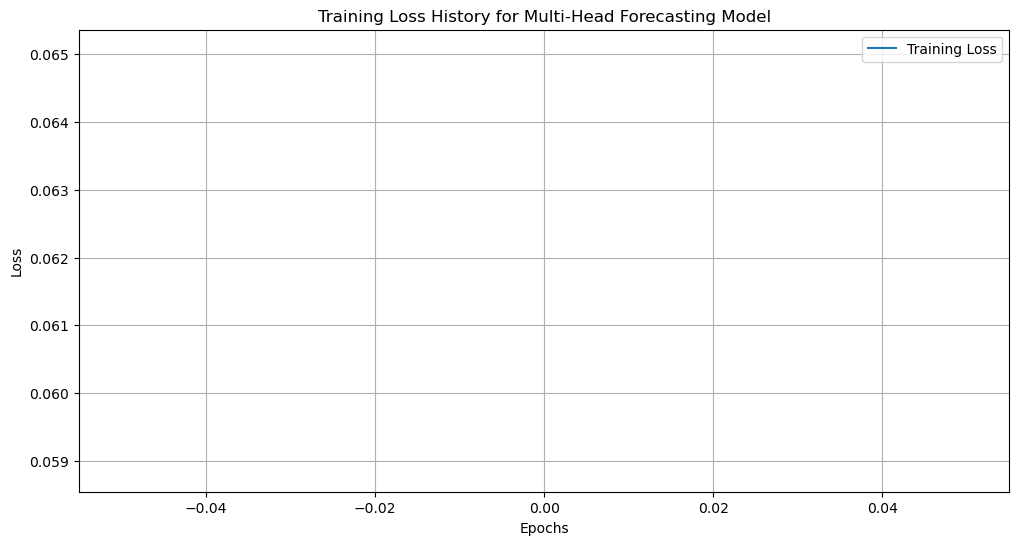

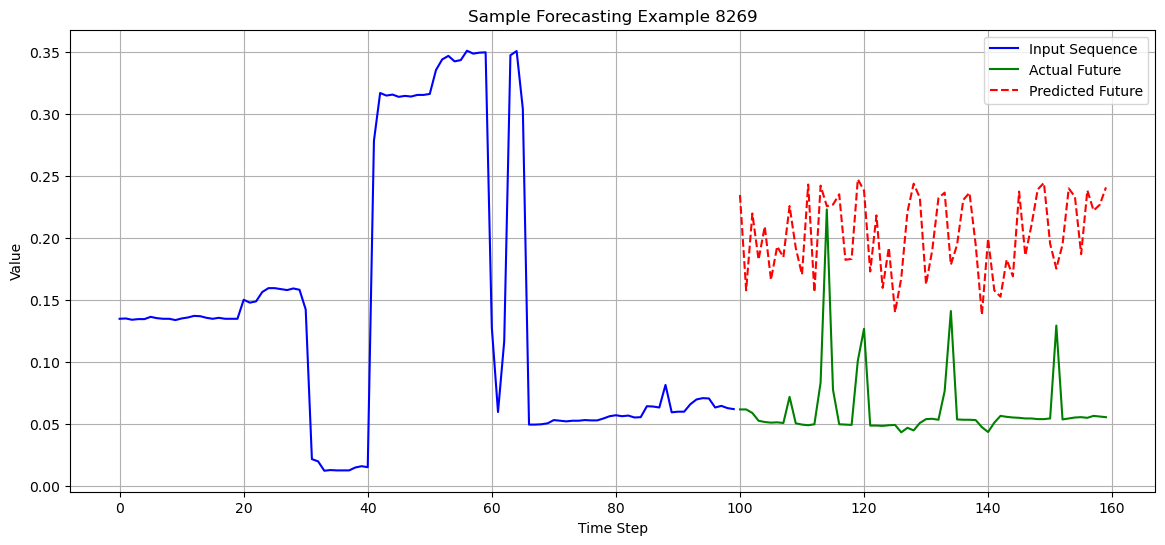

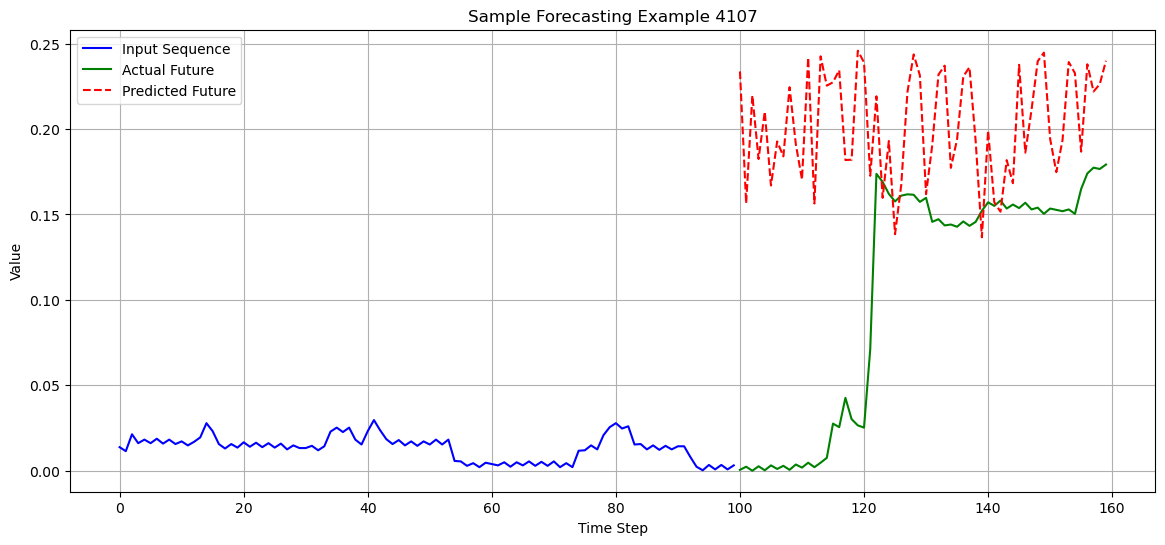

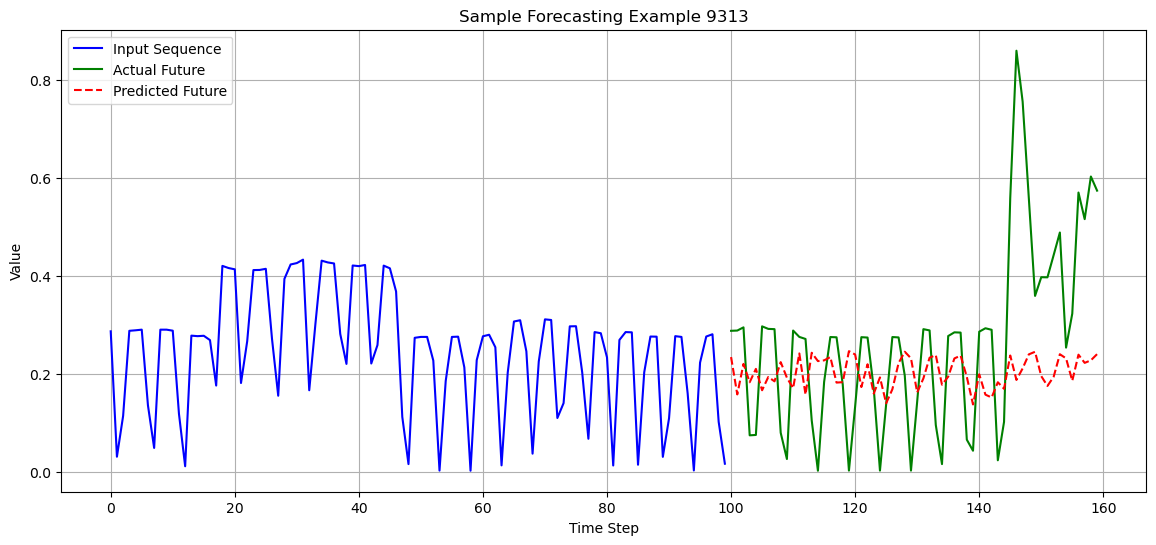

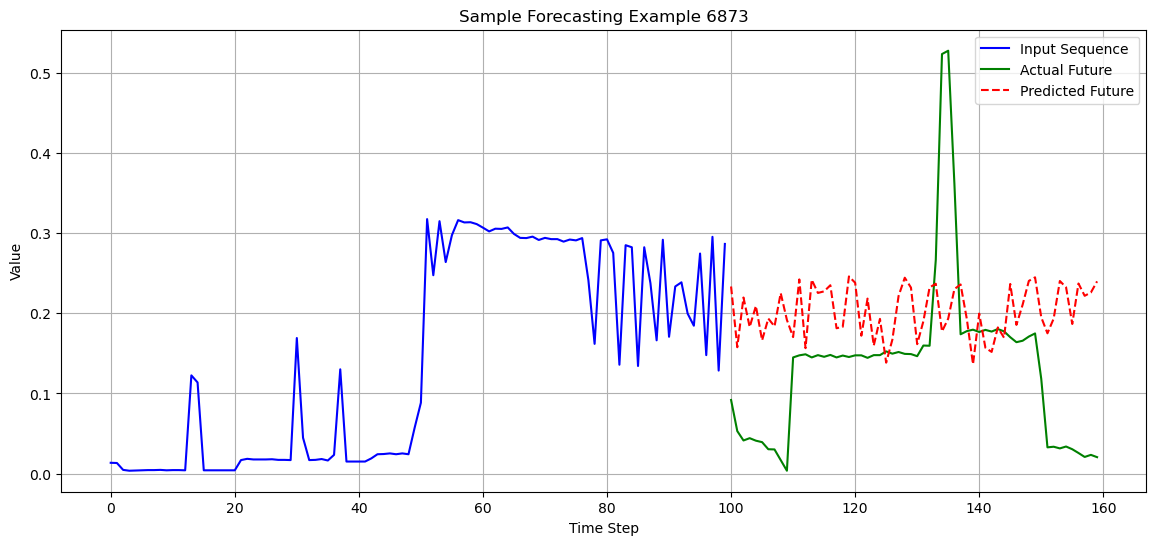

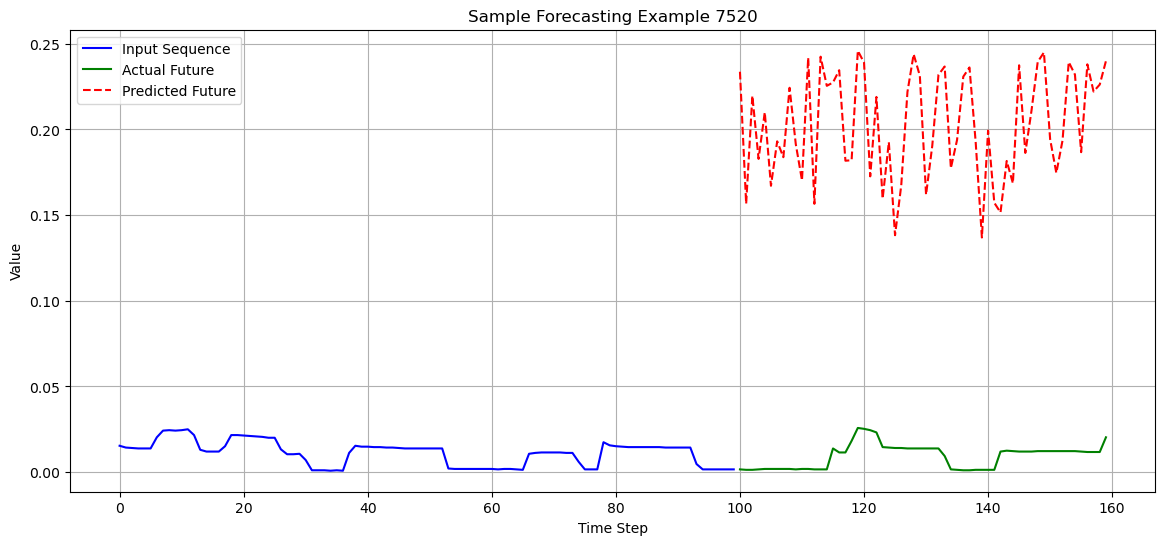

In [60]:


# Plot the training loss for the multi-head forecasting model
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss History for Multi-Head Forecasting Model")
plt.legend()
plt.grid(True)
plt.show()

multihead_forecasting_model.eval()
# Visualization of model's predictions
sample_idx = np.random.choice(len(X_train), 5, replace=False)
for idx in sample_idx:
    sample_input = X_train[idx].unsqueeze(0)
    actual_output = y_train[idx]
    predicted_output = multihead_forecasting_model(sample_input)


    
    plt.figure(figsize=(14, 6))
    plt.plot(range(input_window_size), sample_input[0, :, 0].detach().cpu(), label="Input Sequence", color="blue")
    plt.plot(range(input_window_size, input_window_size + forecast_steps), actual_output[:, 0].detach().cpu(), label="Actual Future", color="green")
    plt.plot(range(input_window_size, input_window_size + forecast_steps), predicted_output[0, :, 0].detach().cpu(), label="Predicted Future", color="red", linestyle="--")
    plt.title(f"Sample Forecasting Example {idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

Displaying ellipses for Layer 1


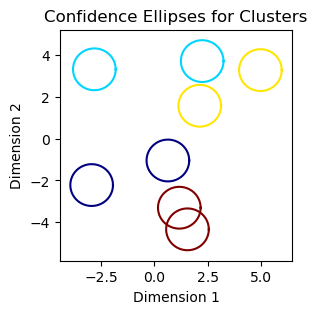

TypeError: 'AxesSubplot' object is not subscriptable

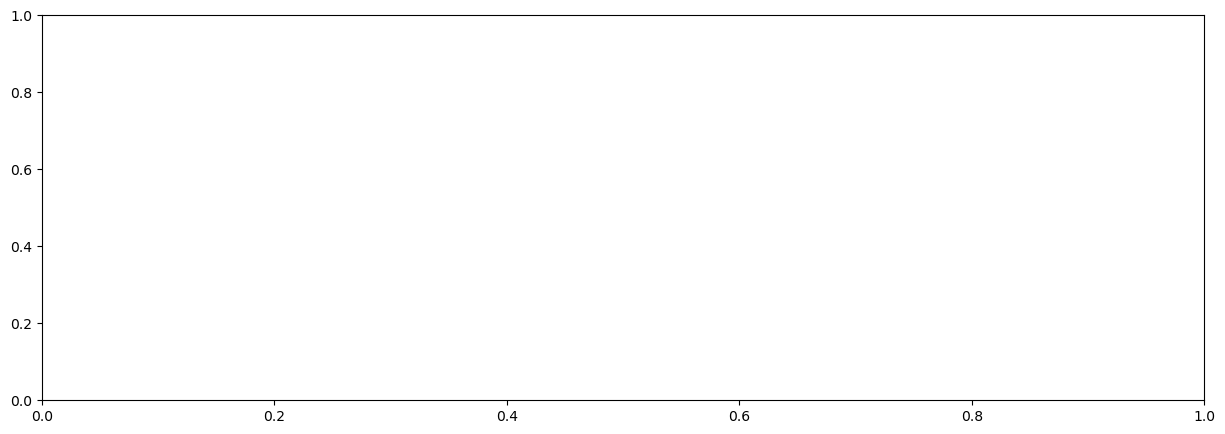

In [ ]:
from numpy.linalg import inv
from numpy import linalg as LA
import numpy as np
import math

# Extract mus and sigma_invs from model_with_positional_embedding
mus_model = []
sigma_invs_model = []

# Loop through each layer and then each head's parameters
for layer in model_with_positional_embedding.layers:
    for head_mus, head_sigma_invs in zip(layer.mus, layer.sigma_invs):
        for layer_mu, layer_sigma_inv in zip(head_mus, head_sigma_invs):
            mus_model.append(layer_mu.detach().cpu().numpy())
            sigma_invs_model.append(layer_sigma_inv.detach().cpu().numpy())

mus_model[0].shape, sigma_invs_model[0].shape  # Display the shape of the first mu and sigma_inv for verification

# Adjust the Ellipse class to handle the provided shapes of mu and Sigma
class EllipseAdjusted():
    def __init__(self, Sigma, mu, n_std=1):
        self.Sigma = Sigma
        self.mu = mu
        self.n_std = n_std
        self.n_s = 100
        
    def compute_confidence_ellipse(self):
        ellipse = np.zeros((self.n_s, 2))
        w, v = LA.eig(self.Sigma)
        kot = np.linspace(0, 2 * math.pi, self.n_s, endpoint=True).reshape([-1, 1])
        rotation = np.concatenate((np.cos(kot), np.sin(kot)), axis=1)
        distance = np.matmul(np.diag(np.sqrt(w)) * self.n_std, v)
        ellipse = np.matmul(rotation, distance)
        ellipse = ellipse + self.mu
        return ellipse

# Adjust the display function to use the new EllipseAdjusted class
def display_clustering_adjusted(sigma_inv_list, mu_list):
    # Create a new figure
    fig, ax = plt.subplots(figsize=(3, 3))
    
    # Use a colormap
    color_map = plt.get_cmap('jet')
    colors = [color_map(i) for i in np.linspace(0, 1, len(mu_list))]
    
    for sigma_inv, mu, c in zip(sigma_inv_list, mu_list, colors):
        sigma = inv(sigma_inv)  # Convert sigma_inv to sigma
        for cluster_idx in range(mu.shape[0]):
            # Extract ellipses for each cluster
            ellipse_obj = EllipseAdjusted(sigma[cluster_idx], mu[cluster_idx])
            ellipse_points = ellipse_obj.compute_confidence_ellipse()
            ax.plot(ellipse_points[:, 0], ellipse_points[:, 1], color=c, label=f'Cluster {cluster_idx+1}')

    plt.title('Confidence Ellipses for Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(False)
    plt.show()

# Display the ellipses using the adjusted function
#display_clustering_adjusted([sigma_invs_model[0][:, :2, :2]], [mus_model[0][:, :2]])

# Group the mus and sigma_invs by layers
mus_by_layers = []
sigma_invs_by_layers = []

layer_size = len(model_with_positional_embedding.layers[0].mus)
for i in range(0, len(mus_model), layer_size):
    mus_by_layers.append(mus_model[i:i+layer_size])
    sigma_invs_by_layers.append(sigma_invs_model[i:i+layer_size])

# Display ellipses for each layer, focusing on the first two dimensions
for layer_idx, (mus_layer, sigma_invs_layer) in enumerate(zip(mus_by_layers, sigma_invs_by_layers)):
    print(f"Displaying ellipses for Layer {layer_idx + 1}")
    display_clustering_adjusted([sigma_inv[:, :2, :2] for sigma_inv in sigma_invs_layer], [mu[:, :2] for mu in mus_layer])
    
def plot_ellipses_in_subplot(ax, sigma_invs, mus, title):
    """Plot ellipses in a given subplot."""
    color_map = plt.get_cmap('jet')
    colors = [color_map(i) for i in np.linspace(0, 1, len(mus))]
    
    for sigma_inv, mu, c in zip(sigma_invs, mus, colors):
        # Only consider the first two dimensions for visualization
        sigma_inv_2d = sigma_inv[:, :2, :2]
        sigma_inv_reg = sigma_inv_2d + 1e-5 * np.eye(2)  # Regularize the matrix for inversion
        sigma = inv(sigma_inv_reg)
        for cluster_idx in range(mu.shape[0]):
            ellipse_obj = EllipseAdjusted(sigma[cluster_idx], mu[cluster_idx, :2])
            ellipse_points = ellipse_obj.compute_confidence_ellipse()
            ax.plot(ellipse_points[:, 0], ellipse_points[:, 1], color=c, label=f'Cluster {cluster_idx+1}')
    
    ax.set_title(title)
    ax.set_xlabel('Dimension 1')
    if title.endswith("1"):
        ax.set_ylabel('Dimension 2')
    ax.grid(False)
    
# Create a single figure with subplots
fig, axs = plt.subplots(1, len(mus_by_layers), figsize=(15, 5))

for idx, (mus_layer, sigma_invs_layer) in enumerate(zip(mus_by_layers, sigma_invs_by_layers)):
    plot_ellipses_in_subplot(axs[idx], sigma_invs_layer, mus_layer, f"Layer {idx + 1}")

plt.tight_layout()
plt.show()


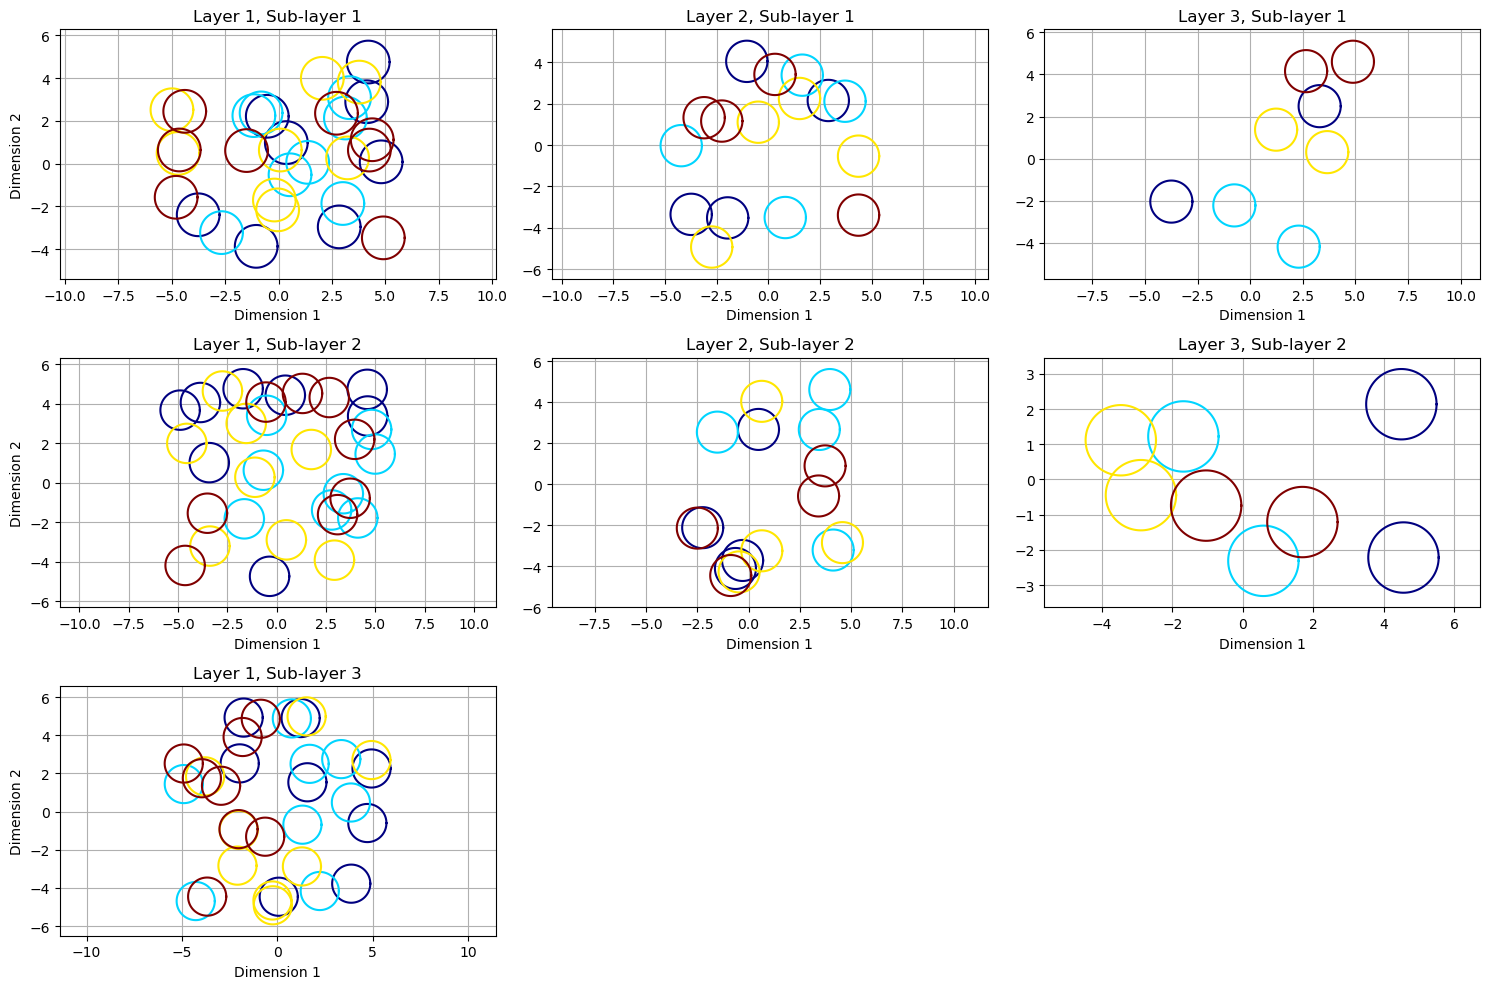

In [ ]:
# Adjust the plotting function for the new arrangement
def plot_ellipses_in_subplot(ax, sigma_invs, mus, layer_num, sublayer_num):
    """Plot ellipses in a given subplot with detailed titles."""
    color_map = plt.get_cmap('jet')
    colors = [color_map(i) for i in np.linspace(0, 1, len(mus))]
    
    for sigma_inv, mu, c in zip(sigma_invs, mus, colors):
        sigma_inv_2d = sigma_inv[:, :2, :2]
        sigma_inv_reg = sigma_inv_2d + 1e-5 * np.eye(2)  # Regularize the matrix for inversion
        sigma = inv(sigma_inv_reg)
        for cluster_idx in range(mu.shape[0]):
            ellipse_obj = EllipseAdjusted(sigma[cluster_idx], mu[cluster_idx, :2])
            ellipse_points = ellipse_obj.compute_confidence_ellipse()
            ax.plot(ellipse_points[:, 0], ellipse_points[:, 1], color=c)
    
    ax.set_title(f"Layer {layer_num}, Sub-layer {sublayer_num}")
    ax.set_xlabel('Dimension 1')
    if layer_num == 1:
        ax.set_ylabel('Dimension 2')
    ax.grid(True)
    ax.axis('equal')  # Equal axes

# Create a single figure with subplots
fig, axs = plt.subplots(max(num_fuzzy_layers_list), len(num_fuzzy_layers_list), figsize=(15, 10))

# To keep track of the extracted mus and sigma_invs
idx = 0

for layer_num, num_sublayers in enumerate(num_fuzzy_layers_list, start=1):
    for sublayer_num in range(1, num_sublayers + 1):
        plot_ellipses_in_subplot(axs[sublayer_num - 1][layer_num - 1], sigma_invs_by_layers[idx], mus_by_layers[idx], layer_num, sublayer_num)
        idx += 1

# Hide any unused subplots
for sublayer_num in range(max(num_fuzzy_layers_list)):
    for layer_num in range(len(num_fuzzy_layers_list)):
        if sublayer_num + 1 > num_fuzzy_layers_list[layer_num]:
            axs[sublayer_num][layer_num].axis('off')

plt.tight_layout()
plt.show()
